In [1]:
import gc

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import confusion_matrix

from src.utils import calculate_profit, train_val_test_split, signed_log10_1p

## Construct the `profit` and `profitable` variables

In [2]:
funnel = pd.read_csv('train_data/funnel.csv')
funnel['profit'] = calculate_profit(funnel)
funnel['log_profit'] = funnel['profit'].apply(signed_log10_1p)
funnel['profitable'] = (funnel['profit'] > 0).astype(int)

## Construct balances

I'll try to get last balance, and then difference from last balance for last few months

In [3]:
balances = pd.read_csv('train_data/balance.csv')

In [4]:
# Sum up across all accounts
account_sums = balances.groupby(['client_id', 'month_end_dt'])[['avg_bal_sum_rur', 'max_bal_sum_rur', 'min_bal_sum_rur']].sum()

# Get average range (max - min) for all clients
account_sums['range'] = account_sums['max_bal_sum_rur'] - account_sums['min_bal_sum_rur']
avg_range = account_sums['range'].mean(level='client_id', skipna=True)

# Get the average amount in the last month
last_month_avg = account_sums.iloc[account_sums.index.get_level_values('month_end_dt') == '2019-08-31']
last_month_avg = last_month_avg['avg_bal_sum_rur']
last_month_avg.index = last_month_avg.index.droplevel('month_end_dt')

# Get differences from the average in the last month
account_sums['diff_last_month'] = account_sums['avg_bal_sum_rur'] - last_month_avg
diffs = account_sums['diff_last_month'].reset_index().query('month_end_dt != "2019-08-31"')
diffs = diffs.pivot(index='client_id', columns='month_end_dt')

# Put together all balance features
diffs.columns = [f'balance_diff_{c[1]}' for c in diffs.columns]
balance_ft = diffs
balance_ft['avg_range'] = avg_range
balance_ft['last_month_avg'] = last_month_avg

In [5]:
balance_ft.describe()

,balance_diff_2018-09-30,balance_diff_2018-10-31,balance_diff_2018-11-30,balance_diff_2018-12-31,balance_diff_2019-01-31,balance_diff_2019-02-28,balance_diff_2019-03-31,balance_diff_2019-04-30,balance_diff_2019-05-31,balance_diff_2019-06-30,balance_diff_2019-07-31,avg_range,last_month_avg
count,16455.000000,16710.000000,17056.000000,17412.000000,17633.000000,17942.000000,18271.000000,18423.000000,18582.000000,18605.000000,18618.000000,18619.000000,18619.000000
mean,87.988210,51.673190,46.710483,33.441822,17.955481,10.769981,4.449948,8.166042,5.379130,6.465090,4.418520,52.000720,-90.814759
std,1884.751453,1181.022633,1157.721772,950.131726,553.243603,547.045252,498.944701,476.696726,352.540639,324.753785,262.595122,172.862765,934.295467
min,-38052.000000,-25178.000000,-24428.000000,-23909.000000,-23319.000000,-22554.000000,-21500.000000,-21311.000000,-21300.000000,-21454.000000,-20211.000000,0.000000,-31173.000000
25%,-5.000000,-7.000000,-8.000000,-8.000000,-10.000000,-11.000000,-13.000000,-10.000000,-8.000000,-5.000000,-2.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.833333,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.833333,7.000000
max,108444.000000,77117.000000,77565.000000,76899.000000,11144.000000,13059.000000,12013.000000,22115.000000,11144.000000,11144.000000,5795.000000,7792.083333,38052.000000


## Construct AUM

Same as with balances, but now for assets under managament

In [6]:
aum = pd.read_csv('train_data/aum.csv')

In [7]:
# Sum up across all accounts
aum_sums = aum.groupby(['client_id', 'month_end_dt'])[['balance_rur_amt']].sum()

# Get STD for last few months for client
aum_std = aum_sums.std(level='client_id', skipna=True)

# Get the average amount in the last month
last_month_aum = aum_sums.iloc[aum_sums.index.get_level_values('month_end_dt') == '2019-08-31']
last_month_aum = last_month_aum['balance_rur_amt']
last_month_aum.index = last_month_aum.index.droplevel('month_end_dt')

# Get differences from the average in the last month
aum_sums['diff_last_month'] = aum_sums['balance_rur_amt'] - last_month_aum
diffs = aum_sums['diff_last_month'].reset_index().query('month_end_dt != "2019-08-31"')
diffs = diffs.pivot(index='client_id', columns='month_end_dt')

# Put together all balance features
diffs.columns = [f'aum_diff_{c[1]}' for c in diffs.columns]
aum_ft = diffs
aum_ft['aum_std'] = aum_std
aum_ft['aum_last_month'] = last_month_aum

In [8]:
aum_ft.describe()

,aum_diff_2018-11-30,aum_diff_2018-12-31,aum_diff_2019-01-31,aum_diff_2019-02-28,aum_diff_2019-03-31,aum_diff_2019-04-30,aum_diff_2019-05-31,aum_diff_2019-06-30,aum_diff_2019-07-31,aum_std,aum_last_month
count,8.608000e+03,9.813000e+03,9.955000e+03,1.028500e+04,1.064800e+04,1.092600e+04,1.109900e+04,1.133700e+04,1.145600e+04,1.233600e+04,1.155000e+04
mean,-5.001248e+04,-2.714613e+04,-3.435988e+04,-2.387928e+04,-2.682130e+04,-7.292388e+03,-5.554313e+03,3.399581e+02,3.206510e+03,6.753699e+04,1.689718e+05
std,7.507566e+05,6.796489e+05,6.416814e+05,5.892972e+05,4.643446e+05,3.769064e+05,3.329760e+05,3.086190e+05,2.129571e+05,3.048220e+05,9.854516e+05
min,-4.330515e+07,-4.239884e+07,-3.872596e+07,-2.954090e+07,-2.162469e+07,-2.158606e+07,-2.151494e+07,-2.193740e+07,-7.659409e+06,0.000000e+00,-2.078000e+03
25%,-3.222175e+04,-1.827500e+04,-2.341400e+04,-1.804400e+04,-2.073700e+04,-1.057550e+04,-1.231750e+04,-8.498000e+03,-6.059500e+03,3.975839e+03,4.910000e+02
50%,-6.750000e+02,0.000000e+00,-1.450000e+02,0.000000e+00,-2.040000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.461534e+04,1.172700e+04
75%,7.150000e+03,1.319900e+04,3.943000e+03,7.215000e+03,2.927000e+03,1.339375e+04,8.011000e+03,1.158000e+04,8.908000e+03,4.718967e+04,6.347625e+04
max,7.367170e+06,7.980098e+06,8.014740e+06,1.427104e+07,1.026630e+07,1.093164e+07,7.523952e+06,4.848174e+06,1.108082e+07,1.942198e+07,6.464412e+07


## Construct client dataset

In [9]:
client = pd.read_csv('train_data/client.csv')

In [10]:
# Take out citizenship and job_type, they are useless
client_ft = client.set_index('client_id')[['gender', 'age', 'region', 'city', 'education']]

# Filter out cities and region to only those above 200, make them categorical (not numerical)
region_counts = client_ft['region'].value_counts(dropna=False)
top_regions = region_counts[region_counts > 200].index

city_counts = client_ft['city'].value_counts(dropna=False)
top_cities = city_counts[city_counts > 200].index

client_ft.loc[~ client_ft['city'].isin(top_cities), 'city'] = None
client_ft.loc[~ client_ft['region'].isin(top_regions), 'region'] = None

client_ft['city'] = client_ft['city'].astype('str')
client_ft['region'] = client_ft['region'].astype('str')

client_ft[['gender', 'education']] = client_ft[['gender', 'education']].fillna('nan')

In [11]:
client_ft.describe(include='all')

,gender,age,region,city,education
count,21498,21495.000000,21498,21498,21498
unique,3,NaN,29,17,8
top,F,NaN,nan,nan,nan
freq,11116,NaN,4461,13862,12218
mean,NaN,43.097139,NaN,NaN,NaN
std,NaN,10.798968,NaN,NaN,NaN
min,NaN,21.000000,NaN,NaN,NaN
25%,NaN,34.000000,NaN,NaN,NaN
50%,NaN,42.000000,NaN,NaN,NaN
75%,NaN,52.000000,NaN,NaN,NaN


## Construct transaction features

In [12]:
column_names = ['client_id', 'tran_amt_rur', 'mcc_cd']
transaction = pd.read_csv('data/trxn.csv', usecols=column_names)
transaction_ft = transaction[column_names]
del transaction
gc.collect()
transaction_ft['mcc_cd'] = transaction_ft['mcc_cd'].astype('str')

temp_trs = transaction_ft.groupby(['client_id', 'mcc_cd']).sum().reset_index()
transaction_ft = temp_trs.loc[temp_trs.groupby('client_id').tran_amt_rur.idxmax()]
transaction_ft = transaction_ft.set_index('client_id')
transaction_ft['tran_amt_rur'] = transaction_ft['tran_amt_rur'].fillna('nan')
del temp_trs
gc.collect()

0

## Construct final dataset

In [13]:
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable', 'log_profit']
CAT_FEATURES = ['gender', 'region', 'city', 'education', 'mcc_cd']

labels_all = funnel.set_index('client_id')[LABEL_COLS]
full_data = pd.concat([
    labels_all,
    balance_ft,
    aum_ft,
    client_ft,
    transaction_ft
], axis=1)
full_data = full_data.fillna({'mcc_cd': 'nan'})

## Split into train, val, test

In [14]:
train, val, test = train_val_test_split(full_data, [0.8, 0.1, 0.1])

train_pool = Pool(
    data = train.drop(LABEL_COLS, axis=1),
    label = train['log_profit'],
    cat_features=CAT_FEATURES
)

val_pool = Pool(
    data = val.drop(LABEL_COLS, axis=1), 
    label = val['log_profit'],
    cat_features=CAT_FEATURES
)
test_pool = Pool(data = test.drop(LABEL_COLS, axis=1), cat_features=CAT_FEATURES)

print(val.profit.mean())
print(test.profit.mean())
print(train.profit.mean())

3043.2036976744193
2805.0767441860467
2501.6929265030817


## Construct model

In [15]:
model = CatBoostRegressor(
    iterations=1500,
    depth=10,
    loss_function='RMSE',
    use_best_model=True,
)

## Run training

In [16]:
model.fit(train_pool, eval_set=val_pool, verbose=100)

Learning rate set to 0.061276
0:	learn: 2.8612038	test: 2.9120829	best: 2.9120829 (0)	total: 91.5ms	remaining: 2m 17s
100:	learn: 2.0566538	test: 2.3829684	best: 2.3812057 (88)	total: 3.97s	remaining: 55s
200:	learn: 1.8531358	test: 2.3788425	best: 2.3760417 (181)	total: 7.54s	remaining: 48.7s
300:	learn: 1.6639361	test: 2.3757324	best: 2.3737860 (280)	total: 11.4s	remaining: 45.4s
400:	learn: 1.5172364	test: 2.3814657	best: 2.3737860 (280)	total: 15.5s	remaining: 42.6s
500:	learn: 1.4001331	test: 2.3850887	best: 2.3737860 (280)	total: 20.4s	remaining: 40.7s
600:	learn: 1.2923893	test: 2.3917503	best: 2.3737860 (280)	total: 26s	remaining: 38.9s
700:	learn: 1.2067038	test: 2.3940581	best: 2.3737860 (280)	total: 31.6s	remaining: 36.1s
800:	learn: 1.1404707	test: 2.3965107	best: 2.3737860 (280)	total: 37.6s	remaining: 32.8s
900:	learn: 1.0776253	test: 2.3973326	best: 2.3737860 (280)	total: 42.6s	remaining: 28.4s
1000:	learn: 1.0198832	test: 2.3993343	best: 2.3737860 (280)	total: 47.7s	rem

## Evaluate profitability of solution on val

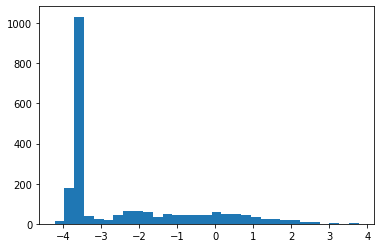

In [17]:
import matplotlib.pyplot as plt
plt.hist(model.predict(val_pool), bins=31);

In [18]:
for threshold in np.arange(-3, -1, 0.1):
    pred_val = model.predict(val_pool) > threshold
    bs_prof_val = val['profit'].mean()

    model_prof_val = calculate_profit(val)[pred_val.astype(bool)].sum()
    model_prof_val = model_prof_val / len(pred_val)

    print(f'VAL {threshold} | Baseline profit: {bs_prof_val:.2f}, model profit: {model_prof_val:.2f}')

VAL -3.0 | Baseline profit: 3043.20, model profit: 5804.97
VAL -2.9 | Baseline profit: 3043.20, model profit: 5841.07
VAL -2.8 | Baseline profit: 3043.20, model profit: 5834.61
VAL -2.6999999999999997 | Baseline profit: 3043.20, model profit: 5849.50
VAL -2.5999999999999996 | Baseline profit: 3043.20, model profit: 5858.80
VAL -2.4999999999999996 | Baseline profit: 3043.20, model profit: 5861.12
VAL -2.3999999999999995 | Baseline profit: 3043.20, model profit: 5898.33
VAL -2.2999999999999994 | Baseline profit: 3043.20, model profit: 5876.87
VAL -2.1999999999999993 | Baseline profit: 3043.20, model profit: 5820.07
VAL -2.099999999999999 | Baseline profit: 3043.20, model profit: 5780.81
VAL -1.9999999999999991 | Baseline profit: 3043.20, model profit: 5694.38
VAL -1.899999999999999 | Baseline profit: 3043.20, model profit: 5725.65
VAL -1.799999999999999 | Baseline profit: 3043.20, model profit: 5645.99
VAL -1.6999999999999988 | Baseline profit: 3043.20, model profit: 5580.91
VAL -1.59999

In [19]:
threshold = -2.2

## Evaluate profitability of solution on test

In [20]:
pred_test = model.predict(test_pool) > threshold
bs_prof_test = test['profit'].mean()

model_prof_test = calculate_profit(test)[pred_test.astype(bool)].sum()
model_prof_test = model_prof_test / len(pred_test)

print(f'TEST | Baseline profit: {bs_prof_test:.2f}, model profit: {model_prof_test:.2f}')

TEST | Baseline profit: 2805.08, model profit: 5442.63


## Notes

1. Using just balance  or features, I get below baseline
2. Using balance + client features, I get 3074 on test,  3345.24 on val
3. Using balance + aum + client fts, I get 2944.95 on test, 3607.06 on val
4. Same as prev step - but using regressor, I get crazy 5289 on test, 5792 on val
5. Same step as prev, but using signed log on profit + thresholding I get 5906.70 on val, and 5516.17 on test
6. Same as prev + transaction features, I get 5887.00 on val, and 5442.85 ont test

## Save model on FULL data and save it

In [21]:
model.save_model('models/tadej_model.cbm', 'cbm')

## Test load, data and produce predictions

In [22]:
# Save data first, as it would be in the build step
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable']
full_data.drop(LABEL_COLS, axis=1).to_pickle('final_version.pickle')

In [23]:
model = CatBoostRegressor().load_model('models/tadej_model.cbm', 'cbm')
data = pd.read_pickle('final_version.pickle')
data_pool = Pool(data = data, cat_features=CAT_FEATURES)

target = (model.predict(data_pool) > threshold).astype(int)
submission = pd.DataFrame({'client_id': data.index, 'target': target})
submission.to_csv('submission.csv', index=False)

In [24]:
pd.read_csv('submission.csv')

,client_id,target
0,-9221941791080978530,0
1,-9220369594510368140,0
2,-9220236243053692422,1
3,-9220233431709087652,1
4,-9219699286371310531,0
...,...,...
21493,9219024469308275500,0
21494,9219416956046769492,0
21495,9219968212912398941,0
21496,9220335314469087849,0
